In [1]:
# Import necessary Python libraries
import subprocess  # For running external shell commands/R scripts
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation library
import pyfolio as pf  # Financial portfolio analysis tool
import yfinance as yf  # Yahoo Finance data downloader
from sklearn.base import clone  # For cloning machine learning models
import matplotlib.pyplot as plt  # Plotting library
from sklearn.ensemble import RandomForestClassifier  # ML model class

import warnings  # For handling warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

/home/josgt/anaconda3/envs/quantinsti/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Define custom concept drift detection algorithm
class ADDMClassifier:
    def __init__(self, base_model, window_size=100, retrain_size=50, validation_size=250):
        # Initialize drift detector with base ML model and parameters
        self.base_model = base_model  # Core classification model (RF in this case)
        self.window_size = window_size  # Size of error tracking window
        self.retrain_size = retrain_size  # Number of samples for model retraining
        
        self.current_model = None  # Active classification model
        self.error_window = []  # Storage for smoothed error rates
        self.severity = 0.0  # Measure of drift severity
        self.validation_size = validation_size  # Base error calculation window

    def initialize(self, X_train, y_train):
        # Initialize model with training data
        self.current_model = clone(self.base_model)
        self.current_model.fit(X_train, y_train)  # Train initial model
        # Calculate initial validation errors
        y_pred = self.current_model.predict(X_train)
        errors = (y_train != y_pred).astype(int)  # Binary classification errors
        self.validation_errors = self._smooth_errors(errors[-self.validation_size:])  # Smoothed base errors
        self.error_window = self.validation_errors.copy()  # Initialize error window
        self.error_window = []  # Reset error window (possibly redundant)
        # Buffer for storing recent data points
        self.data_buffer = [(x,y) for x, y in zip(X_train.iloc[-self.retrain_size:,:].values, y_train.iloc[-self.retrain_size:].values)]             

    def process_stream(self, X_stream, y_stream):
        # Process streaming data and detect concept drift
        self.results = pd.DataFrame(index=X_stream.index, columns=['addm_signal', 'drift_detected'])
        self.results['drift_detected'] = 0  # Initialize drift detection flags
        
        # Iterate through streaming data
        for num, index, x, y in zip(list(range(len(X_stream.index))), X_stream.index.values, X_stream.values, y_stream.values):
            print('='*50)
            print(f'Date is {index}')
            # Make prediction with current model
            y_pred = self.current_model.predict(x.reshape(1, -1))
            self.results.loc[index,'addm_signal'] = y_pred  # Store prediction
            
            # Calculate prediction error
            error = int(y != y_pred[0])  # Binary error indicator
            
            # Update smoothed error window (10-period moving average)
            smoothed_error = np.mean([error] + self.error_window[-9:])
            self.error_window.append(smoothed_error)
            
            # Maintain data buffer with recent observations
            self.data_buffer.append((x, y))

            # Enforce window size limits
            if len(self.error_window) > self.window_size:
                self.error_window.pop(0)
            if len(self.data_buffer) > 2 * self.retrain_size:
                self.data_buffer.pop(0)

            # Combine validation errors with current errors
            self.setar_series = self.validation_errors + self.error_window[-min(num,self.window_size):]

            # Save error data for external analysis
            models_errors_df = pd.DataFrame(self.setar_series, columns=['models_errors'])
            models_errors_df['regime'] = 1  # Initialize regime column
            models_errors_df.to_excel('models_errors.xlsx')  # Write to Excel

            # Execute R script for regime detection
            subprocess.run(['Rscript',"SETAR.R"])  # Call external R analysis
            # Call the R script in Windows. Change the address as per where your Rscript is located on your PC
            #address = 'C:/Program Files/R/R-4.2.2/bin/'
            #subprocess.run([address+'Rscript',"Estimate_ARFIMA.R"])
            
            # Read regime classification results
            current_regime = pd.read_excel('models_errors.xlsx', index_col=0)['regime'].iloc[-1]

            if current_regime != 0:
                # Check for regime change (drift detection)
                if hasattr(self, 'last_regime'):
                    if current_regime != self.last_regime:
                        print("Drift detected! Updating model...")
                        self.results.loc[index,'drift_detected'] = 1  # Flag drift
                        self._calculate_severity()  # Compute drift severity
                        self._update_model()  # Retrain model
                self.last_regime = current_regime  # Track current regime

            self.results.to_excel('temp_results.xlsx')  # Save interim results

    def _calculate_severity(self):
        # Calculate severity of detected drift
        split_idx = len(self.setar_series) - self.validation_size
        old_errors = self.setar_series[:split_idx]  # Pre-drift errors
        new_errors = self.setar_series[split_idx:]  # Post-drift errors
        Q3_old = np.quantile(old_errors, 0.75)  # 75th percentile of old
        Q3_new = np.quantile(new_errors, 0.75)  # 75th percentile of new
        self.severity = max(Q3_old, Q3_new) / (Q3_old + Q3_new)  # Severity metric

    def _update_model(self):
        # Update model with recent data
        recent_X = np.array([x for x, y in self.data_buffer[-self.retrain_size:]])
        recent_y = np.array([y for x, y in self.data_buffer[-self.retrain_size:]])
        new_model = clone(self.base_model)  # Fresh model instance
        new_model.fit(recent_X, recent_y)  # Retrain on recent data
        self.current_model = new_model  # Replace current model

    def _smooth_errors(self, errors, window=10):
        # Convert binary errors to smoothed continuous series
        return [np.mean(errors[i:i+window]) for i in range(len(errors) - window + 1)]

In [3]:
# Download Microsoft stock data from Yahoo Finance
data = yf.download('MSFT', start='2015-01-01', end='2025-03-04', group_by='ticker')['MSFT']
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price             Open        High         Low       Close    Volume
Date                                                                
2015-01-02   39.986428   40.637727   39.883592   40.072124  27913900
2015-01-05   39.737913   40.046424   39.635077   39.703636  39673900
2015-01-06   39.746487   40.063566   39.026628   39.120895  36447900
2015-01-07   39.403703   39.815050   38.983787   39.617947  29114100
2015-01-08   40.063573   40.920548   40.037865   40.783432  29645200
...                ...         ...         ...         ...       ...
2025-02-25  401.100006  401.920013  396.700012  397.899994  29387400
2025-02-26  398.010010  403.600006  394.250000  399.730011  19619000
2025-02-27  401.269989  405.739990  392.170013  392.529999  21127400
2025-02-28  392.660004  397.630005  386.570007  396.989990  32845700
2025-03-03  398.820007  398.820007  386.160004  388.489990  23007700

[2556 rows x 5 columns]

In [4]:
# Create feature set using percentage changes
ready_data = data[['Open', 'High', 'Low', 'Close']].pct_change()
# Create target variable (1 if next day's close increases)
ready_data['y'] = np.where(data['Close'].pct_change().shift(-1)>0,1,0)
ready_data.dropna(inplace=True)  # Remove missing values
ready_data

Price           Open      High       Low     Close  y
Date                                                 
2015-01-05 -0.006215 -0.014551 -0.006231 -0.009196  0
2015-01-06  0.000216  0.000428 -0.015351 -0.014677  1
2015-01-07 -0.008624 -0.006203 -0.001098  0.012706  1
2015-01-08  0.016746  0.027766  0.027039  0.029418  0
2015-01-09  0.018395  0.001466  0.003852 -0.008405  0
...              ...       ...       ...       ... ..
2025-02-25 -0.018139 -0.018199 -0.006561 -0.015099  1
2025-02-26 -0.007704  0.004180 -0.006176  0.004599  0
2025-02-27  0.008191  0.005302 -0.005276 -0.018012  1
2025-02-28 -0.021457 -0.019988 -0.014280  0.011362  0
2025-03-03  0.015688  0.002993 -0.001061 -0.021411  0

[2555 rows x 5 columns]

In [5]:
# Split data into training (2015-2018) and streaming (2019+) sets
last_train_year = 2018
X_train = ready_data.loc[ready_data.index.year<=last_train_year,['Open', 'High', 'Low', 'Close']]
y_train = ready_data.loc[ready_data.index.year<=last_train_year,'y']
X_stream = ready_data.loc[ready_data.index.year>last_train_year,['Open', 'High', 'Low', 'Close']]
y_stream = ready_data.loc[ready_data.index.year>last_train_year,'y']

In [6]:
# Initialize drift detector with Random Forest
base_model = RandomForestClassifier(n_estimators=5, max_depth=3, max_features=1.0, random_state=2025, n_jobs=-2)
detector = ADDMClassifier(base_model, window_size=90, retrain_size=500, validation_size=80)
detector.initialize(X_train, y_train)  # Initial training

# Process streaming data with drift detection
detector.process_stream(X_stream, y_stream)
signal_results = detector.results.copy()  # Store results

Date is 2019-01-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning messages:
1: Possible unit root in the high  regime. Roots are: 0.

Date is 2019-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2019-01-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Drift detected! Updating model...
Date is 2019-01-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2019-01-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9819

Date is 2019-01-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9915

Drift detected! Updating model...
Date is 2019-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9923

Date is 2019-01-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.2964

Date is 2019-02-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.2926

Date is 2019-02-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Drift detected! Updating model...
Date is 2019-02-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Drift detected! Updating model...
Date is 2019-02-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Drift detected! Updating model...
Date is 2019-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Date is 2019-02-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Date is 2019-02-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.368 

Date is 2019-02-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-02-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-03-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-03-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9992

Date is 2019-03-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-03-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9492

Drift detected! Updating model...
Date is 2019-03-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9511

Date is 2019-04-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.949 

Drift detected! Updating model...
Date is 2019-04-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.949 

Date is 2019-04-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.949 

Drift detected! Updating model...
Date is 2019-04-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.996 

Drift detected! Updating model...
Date is 2019-04-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9876

Date is 2019-04-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-04-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-04-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-04-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-04-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-04-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-05-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-05-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-06-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-06-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-07-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-07-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-08-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-09-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-09-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-09-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-09-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-09-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.669 

Date is 2019-10-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-10-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8687

Date is 2019-10-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-10-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-11-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7147

Date is 2019-11-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-11-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7147

Drift detected! Updating model...
Date is 2019-12-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7147

Date is 2019-12-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7259

Drift detected! Updating model...
Date is 2019-12-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2019-12-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2019-12-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the low  regime. Roots are: 0.8874 

Date is 2020-02-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-02-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9952

Date is 2020-03-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-03-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-03-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9969

Date is 2020-04-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9791

Date is 2020-04-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-04-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-05-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9716

Date is 2020-05-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9779

Date is 2020-05-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-05-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9761

Date is 2020-05-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9774

Date is 2020-05-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9774

Date is 2020-05-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9771

Date is 2020-05-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-05-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9761

Date is 2020-05-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9781

Date is 2020-05-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9781

Date is 2020-05-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9781

Date is 2020-05-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9781

Date is 2020-05-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9767

Date is 2020-05-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-05-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9767

Date is 2020-05-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-05-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9967

Date is 2020-05-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9767

Date is 2020-05-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9767

Date is 2020-06-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9688

Date is 2020-06-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-06-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9734

Drift detected! Updating model...
Date is 2020-06-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9763

Date is 2020-06-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2020-06-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9763

Drift detected! Updating model...
Date is 2020-06-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9763

Date is 2020-06-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9934

Date is 2020-06-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9893

Date is 2020-06-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.975 

Date is 2020-06-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9807

Date is 2020-06-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9763

Date is 2020-06-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9763

Date is 2020-06-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9771

Date is 2020-06-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9799

Date is 2020-06-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2020-06-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9935

Date is 2020-07-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9572

Date is 2020-07-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9511

Date is 2020-07-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9527

Date is 2020-07-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9527

Date is 2020-07-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9527

Date is 2020-07-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9807

Date is 2020-07-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9558

Date is 2020-07-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9271

Date is 2020-07-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9185

Date is 2020-07-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9289

Date is 2020-07-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9564

Date is 2020-07-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.925 

Date is 2020-07-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.912 

Date is 2020-07-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8938

Date is 2020-07-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8947

Date is 2020-07-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8947

Date is 2020-07-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8947

Date is 2020-07-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9028

Date is 2020-07-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8937

Date is 2020-07-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-07-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-07-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-08-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-08-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-08-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-08-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8944

Date is 2020-08-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8977

Date is 2020-08-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-08-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-09-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9188

Date is 2020-10-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-10-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8997

Date is 2020-11-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8963

Date is 2020-11-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-11-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8965

Date is 2020-12-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9052

Date is 2020-12-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9006

Drift detected! Updating model...
Date is 2020-12-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8935

Date is 2020-12-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9018

Drift detected! Updating model...
Date is 2020-12-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.892 

Date is 2020-12-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.892 

Drift detected! Updating model...
Date is 2020-12-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.892 

Drift detected! Updating model...
Date is 2020-12-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8891

Date is 2020-12-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8891

Drift detected! Updating model...
Date is 2020-12-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8891

Drift detected! Updating model...
Date is 2020-12-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8864

Date is 2020-12-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8864

Drift detected! Updating model...
Date is 2020-12-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8864

Drift detected! Updating model...
Date is 2020-12-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8841

Date is 2021-01-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8841

Drift detected! Updating model...
Date is 2021-01-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8841

Drift detected! Updating model...
Date is 2021-01-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8902

Date is 2021-01-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8902

Date is 2021-01-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8958

Date is 2021-01-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8902

Date is 2021-01-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8902

Date is 2021-01-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8916

Date is 2021-01-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9144

Drift detected! Updating model...
Date is 2021-01-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8912

Date is 2021-01-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.893 

Drift detected! Updating model...
Date is 2021-01-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8948

Drift detected! Updating model...
Date is 2021-01-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8948

Date is 2021-01-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8948

Drift detected! Updating model...
Date is 2021-01-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.937 

Date is 2021-01-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.937 

Drift detected! Updating model...
Date is 2021-01-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9393

Drift detected! Updating model...
Date is 2021-01-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9324

Drift detected! Updating model...
Date is 2021-01-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9465

Drift detected! Updating model...
Date is 2021-02-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9324

Date is 2021-02-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9465

Date is 2021-02-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9465

Date is 2021-02-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9324

Date is 2021-02-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9465

Date is 2021-02-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9324

Date is 2021-02-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9324

Date is 2021-02-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9287

Date is 2021-02-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-02-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9225

Date is 2021-03-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9211

Date is 2021-03-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9211

Drift detected! Updating model...
Date is 2021-03-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9211

Drift detected! Updating model...
Date is 2021-03-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9501

Date is 2021-03-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9526

Drift detected! Updating model...
Date is 2021-03-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9632

Date is 2021-03-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9578

Date is 2021-03-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9597

Drift detected! Updating model...
Date is 2021-03-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9655

Drift detected! Updating model...
Date is 2021-03-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9597

Drift detected! Updating model...
Date is 2021-03-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9597

Date is 2021-03-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9662

Date is 2021-03-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9646

Drift detected! Updating model...
Date is 2021-03-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9706

Date is 2021-03-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9646

Drift detected! Updating model...
Date is 2021-03-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9709

Date is 2021-03-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9695

Drift detected! Updating model...
Date is 2021-03-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.963 

Date is 2021-03-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9695

Drift detected! Updating model...
Date is 2021-03-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9695

Date is 2021-03-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9681

Date is 2021-03-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9627

Drift detected! Updating model...
Date is 2021-03-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9687

Drift detected! Updating model...
Date is 2021-04-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9705

Drift detected! Updating model...
Date is 2021-04-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9651

Date is 2021-04-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9651

Drift detected! Updating model...
Date is 2021-04-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9711

Date is 2021-04-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9711

Drift detected! Updating model...
Date is 2021-04-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9711

Drift detected! Updating model...
Date is 2021-04-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9711

Date is 2021-04-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9643

Date is 2021-04-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.969 

Drift detected! Updating model...
Date is 2021-04-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9643

Drift detected! Updating model...
Date is 2021-04-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9643

Date is 2021-04-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.969 

Date is 2021-04-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.969 

Date is 2021-04-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.969 

Date is 2021-04-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9684

Date is 2021-04-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9639

Date is 2021-04-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9715

Date is 2021-04-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9691

Date is 2021-04-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9715

Date is 2021-04-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9715

Date is 2021-04-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9715

Date is 2021-05-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9715

Date is 2021-05-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9773

Date is 2021-05-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9866

Drift detected! Updating model...
Date is 2021-05-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9868

Date is 2021-05-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-05-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-05-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-05-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-05-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-05-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-05-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.1933

Drift detected! Updating model...
Date is 2021-06-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-06-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-06-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-07-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-07-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-07-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-07-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-07-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-07-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-08-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-08-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-08-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.338 

Drift detected! Updating model...
Date is 2021-08-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3191

Date is 2021-08-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3241

Drift detected! Updating model...
Date is 2021-08-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3201

Date is 2021-08-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3518

Date is 2021-08-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3518

Date is 2021-09-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.3375

Drift detected! Updating model...
Date is 2021-09-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-09-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-09-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-09-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-09-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-10-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.2172

Drift detected! Updating model...
Date is 2021-11-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.149 

Drift detected! Updating model...
Date is 2021-11-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.1627

Date is 2021-11-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-11-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-11-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.1591

Drift detected! Updating model...
Date is 2021-12-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2021-12-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2021-12-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-01-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-01-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9962

Date is 2022-01-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-03-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:

With the threshold you gave (0.6) there is a regime with

Drift detected! Updating model...
Date is 2022-04-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-04-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:

With the threshold you gave (0.6) there is a regime with

Date is 2022-04-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:

With the threshold you gave (0.6) there is a regime with

Drift detected! Updating model...
Date is 2022-04-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-04-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:

With the threshold you gave (0.6) there is a regime with

Date is 2022-04-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:

With the threshold you gave (0.6) there is a regime with

Drift detected! Updating model...
Date is 2022-04-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-04-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-04-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-05-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-05-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-06-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-06-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8076

Drift detected! Updating model...
Date is 2022-06-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7965

Drift detected! Updating model...
Date is 2022-07-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8082

Drift detected! Updating model...
Date is 2022-07-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8088

Date is 2022-07-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8259

Date is 2022-07-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8344

Date is 2022-07-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8481

Date is 2022-07-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.892 

Date is 2022-07-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-07-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-07-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-07-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-07-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-07-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-07-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9797

Drift detected! Updating model...
Date is 2022-08-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9949

Drift detected! Updating model...
Date is 2022-08-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-08-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9717

Date is 2022-08-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9955

Drift detected! Updating model...
Date is 2022-08-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-08-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9693

Date is 2022-09-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9691

Drift detected! Updating model...
Date is 2022-09-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9704

Drift detected! Updating model...
Date is 2022-09-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9863

Drift detected! Updating model...
Date is 2022-09-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-09-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-09-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-09-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9875

Date is 2022-09-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-09-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-09-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7832

Date is 2022-10-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7832

Date is 2022-10-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7832

Date is 2022-10-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7832

Date is 2022-10-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.7832

Date is 2022-10-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-10-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.5748

Date is 2022-10-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.5951

Drift detected! Updating model...
Date is 2022-10-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-10-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.5663

Drift detected! Updating model...
Date is 2022-10-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Date is 2022-11-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Date is 2022-11-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Date is 2022-11-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6622

Date is 2022-11-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Drift detected! Updating model...
Date is 2022-11-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-11-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6622

Date is 2022-11-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Drift detected! Updating model...
Date is 2022-11-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6622

Drift detected! Updating model...
Date is 2022-11-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6622

Drift detected! Updating model...
Date is 2022-11-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-11-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Drift detected! Updating model...
Date is 2022-11-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-11-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6056

Drift detected! Updating model...
Date is 2022-11-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-12-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.5878

Drift detected! Updating model...
Date is 2022-12-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-12-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.6158

Date is 2022-12-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.441 

Drift detected! Updating model...
Date is 2022-12-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-12-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.569 

Drift detected! Updating model...
Date is 2022-12-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2022-12-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2022-12-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-01-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-01-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-01-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-01-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-02-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-03-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-03-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9194

Drift detected! Updating model...
Date is 2023-03-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-03-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9427

Drift detected! Updating model...
Date is 2023-03-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9518

Date is 2023-03-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-03-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9627

Date is 2023-03-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-03-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-03-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-03-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9627

Date is 2023-03-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-03-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-03-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-03-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9806

Date is 2023-03-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9593

Date is 2023-03-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9593

Date is 2023-03-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9593

Drift detected! Updating model...
Date is 2023-04-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8898

Drift detected! Updating model...
Date is 2023-04-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9531

Date is 2023-04-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9422

Drift detected! Updating model...
Date is 2023-04-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9575

Date is 2023-04-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9377

Drift detected! Updating model...
Date is 2023-04-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-04-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-04-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-05-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-05-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-06-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-07-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-07-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-07-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-08-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-08-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-09-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-09-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-10-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-10-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-11-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-11-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2023-12-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2023-12-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-01-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9844

Drift detected! Updating model...
Date is 2024-02-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9943

Date is 2024-02-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9737

Date is 2024-02-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.985 

Date is 2024-02-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-02-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 1.0238

Drift detected! Updating model...
Date is 2024-02-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9576

Date is 2024-02-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.917 

Date is 2024-02-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9783

Drift detected! Updating model...
Date is 2024-03-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-03-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-03-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-03-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-03-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9027

Date is 2024-03-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9188

Date is 2024-03-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9087

Date is 2024-03-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9173

Drift detected! Updating model...
Date is 2024-03-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9201

Date is 2024-03-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8757

Date is 2024-03-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-03-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.899 

Date is 2024-03-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-03-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9061

Drift detected! Updating model...
Date is 2024-04-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.8577

Date is 2024-04-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-04-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-04-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-05-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-05-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-06-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-06-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-06-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-06-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-06-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-07-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-07-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-07-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-08-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9853

Drift detected! Updating model...
Date is 2024-08-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9765

Drift detected! Updating model...
Date is 2024-08-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9813

Date is 2024-08-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9814

Drift detected! Updating model...
Date is 2024-08-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9812

Date is 2024-08-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-08-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9769

Drift detected! Updating model...
Date is 2024-08-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9674

Drift detected! Updating model...
Date is 2024-08-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9792

Drift detected! Updating model...
Date is 2024-09-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9732

Drift detected! Updating model...
Date is 2024-09-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9964

Drift detected! Updating model...
Date is 2024-09-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-09-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-09-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9856

Date is 2024-09-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
Possible unit root in the high  regime. Roots are: 0.9858

Date is 2024-09-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-10-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-10-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-10-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-10-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-10-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-11-01T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-11-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-11-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-11-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-11-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-09T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-12-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-12-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-12-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2024-12-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2024-12-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-02T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-08T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-15T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-16T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-17T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-22T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-23T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-29T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-30T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-01-31T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-04T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-05T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-06T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-07T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-10T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-11T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-12T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-13T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-14T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-18T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-19T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-20T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-21T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-24T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...
Date is 2025-02-25T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-26T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-27T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-02-28T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Date is 2025-03-03T00:00:00.000000000


Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.27.0 (2024-11-01 18:00:02 UTC) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Drift detected! Updating model...


In [7]:
# Create daily retraining benchmark strategy
ready_data['daily_signal'] = 0.0  # Initialize signal column
for index1 in ready_data.loc[ready_data.index.year>last_train_year,:].index:
    # Sliding window of 1000 observations
    X_train = ready_data.loc[:index1,['Open', 'High', 'Low', 'Close']].iloc[-1000:-1,:]
    X_test = ready_data.loc[:index1,['Open', 'High', 'Low', 'Close']].iloc[-1:,:]
    y_train = ready_data.loc[:index1,'y'].iloc[-1000:-1]
    # Daily model training
    base_model = RandomForestClassifier(n_estimators=5, max_depth=3, max_features=1.0, random_state=2025, n_jobs=-2)
    base_model.fit(X_train, y_train)
    ready_data.loc[index1,'daily_signal'] = base_model.predict(X_test)

In [8]:
# Combine results from both strategies
ready_data = pd.concat([ready_data,signal_results], axis=1).loc[signal_results.index,:]

# Calculate strategy returns
ready_data['addm_stra_rets'] = ready_data['Close']*ready_data['addm_signal'].shift(1)
ready_data['daily_stra_rets'] = ready_data['Close']*ready_data['daily_signal'].shift(1)

# Calculate cumulative returns
ready_data['addm_stra_cum_rets'] = (1+ready_data['addm_stra_rets']).cumprod()
ready_data['daily_stra_cum_rets'] = (1+ready_data['daily_stra_rets']).cumprod()
ready_data['bnh_cum_rets'] = (1+ready_data['Close']).cumprod()  # Buy-and-hold baseline

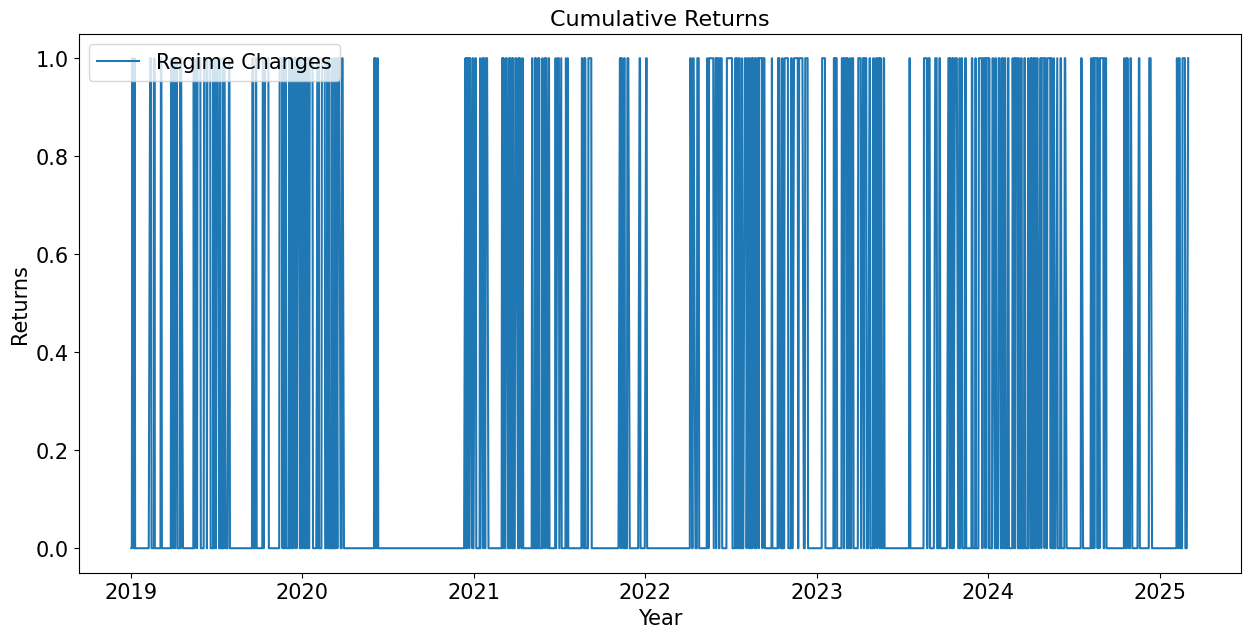

In [9]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative rets
plt.plot(ready_data.index, ready_data['drift_detected'], label = ["Regime Changes"])

# Set the title of the graph
plt.title('Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

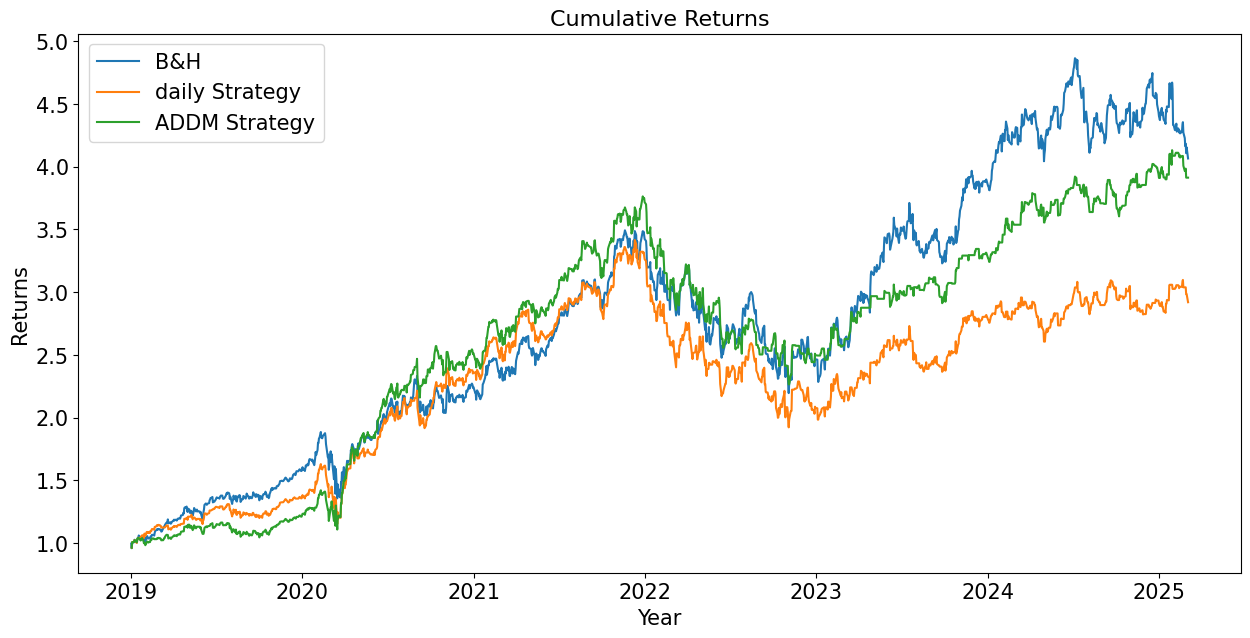

In [10]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative rets
plt.plot(ready_data.index, ready_data[['bnh_cum_rets', 'daily_stra_cum_rets', 'addm_stra_cum_rets']], 
         label = ["B&H", "daily Strategy", "ADDM Strategy"])

# Set the title of the graph
plt.title('Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

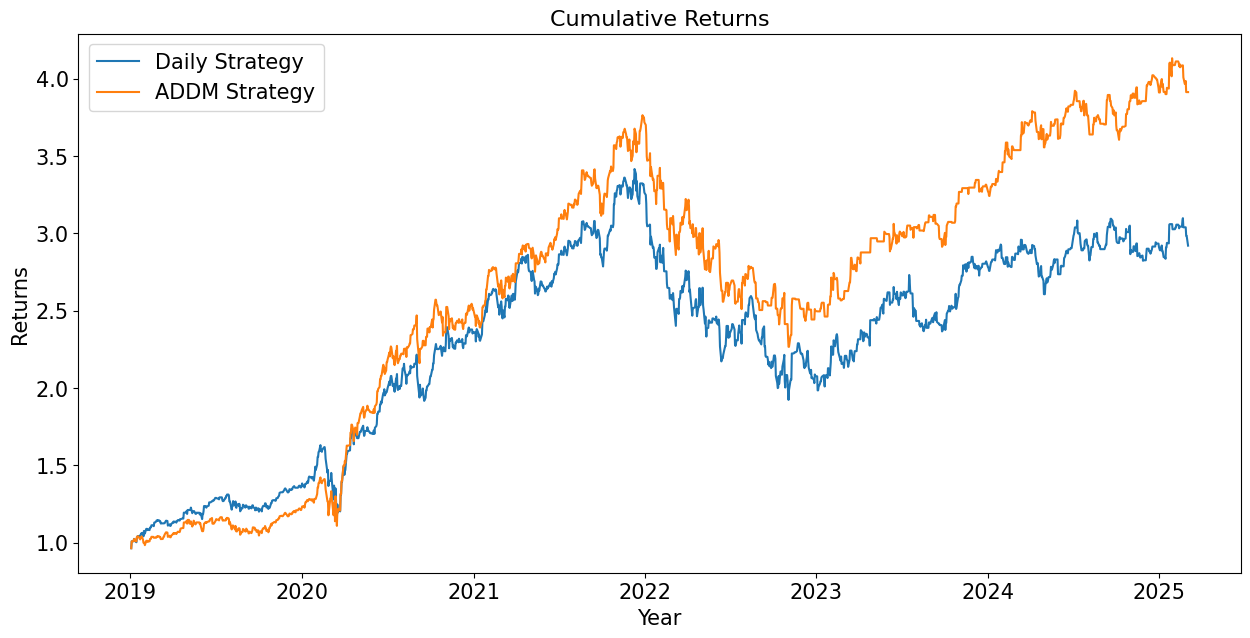

In [11]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold and the strategies' cumulative rets
plt.plot(ready_data.index, ready_data[['daily_stra_cum_rets', 'addm_stra_cum_rets']], 
         label = ["Daily Strategy", "ADDM Strategy"])

# Set the title of the graph
plt.title('Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

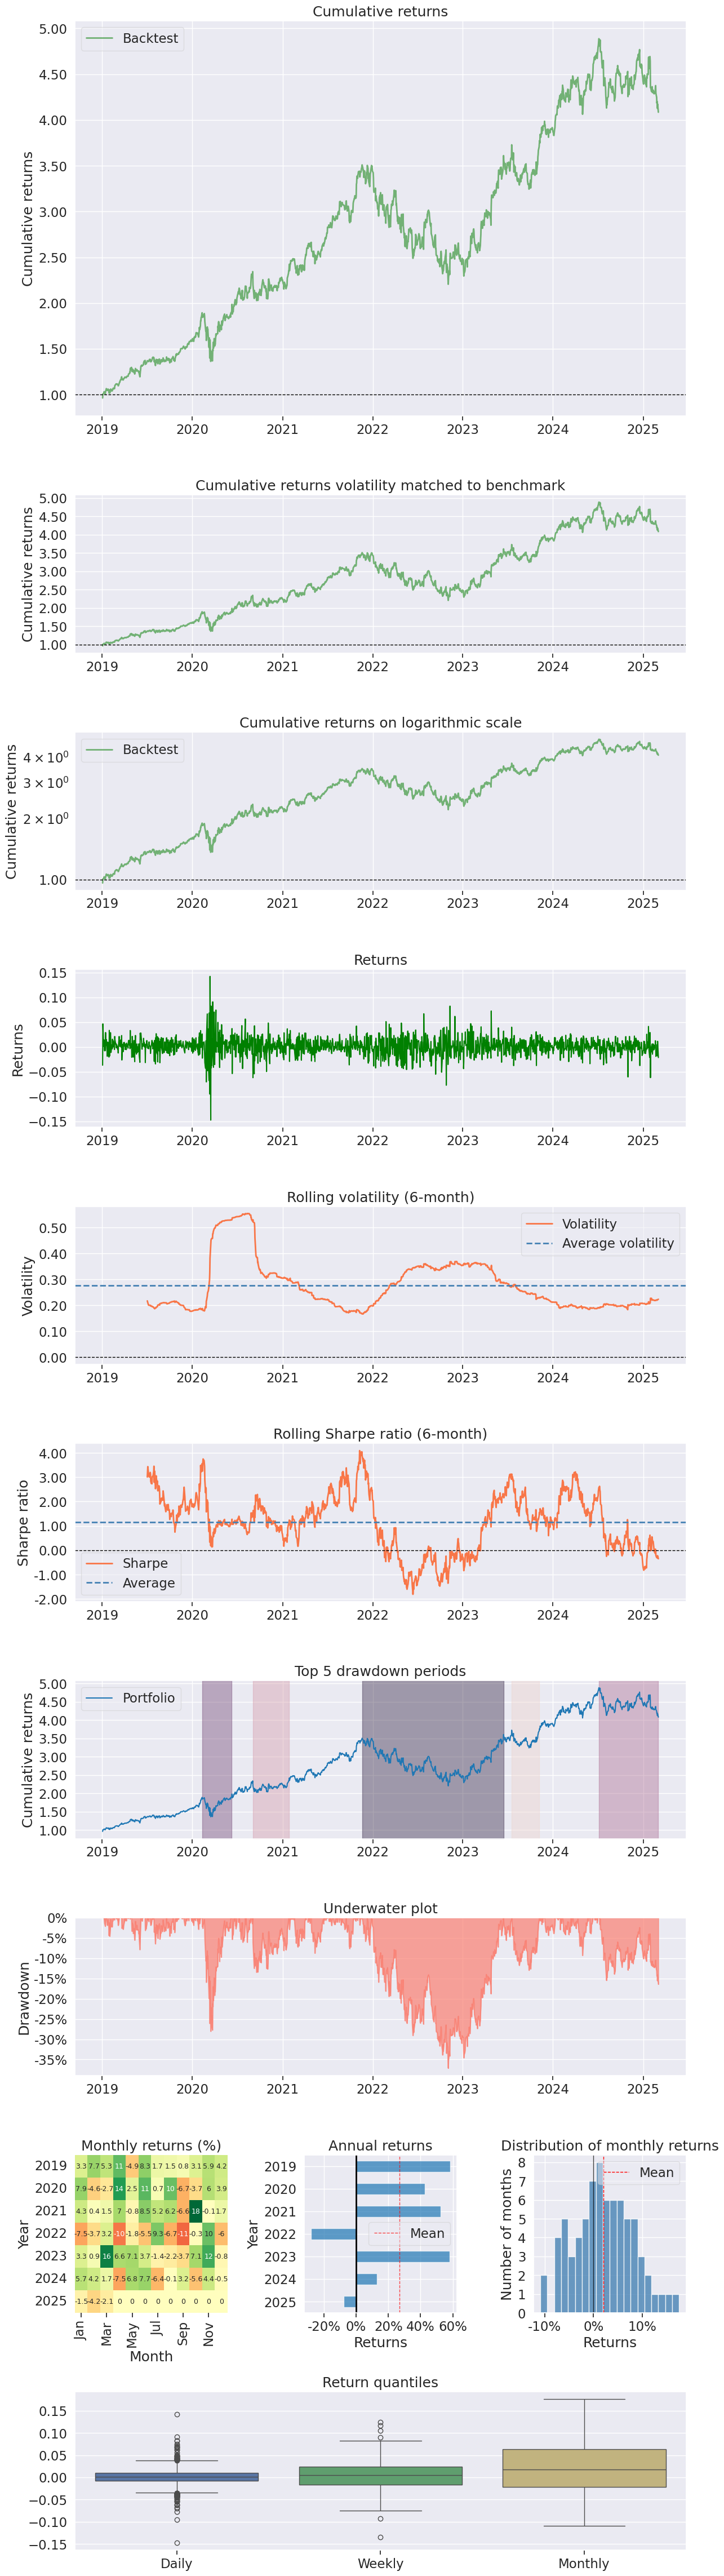

In [12]:
# Create the trading tear sheet for the strategy cumulative returns
pf.create_full_tear_sheet(ready_data['bnh_cum_rets'].pct_change().dropna())

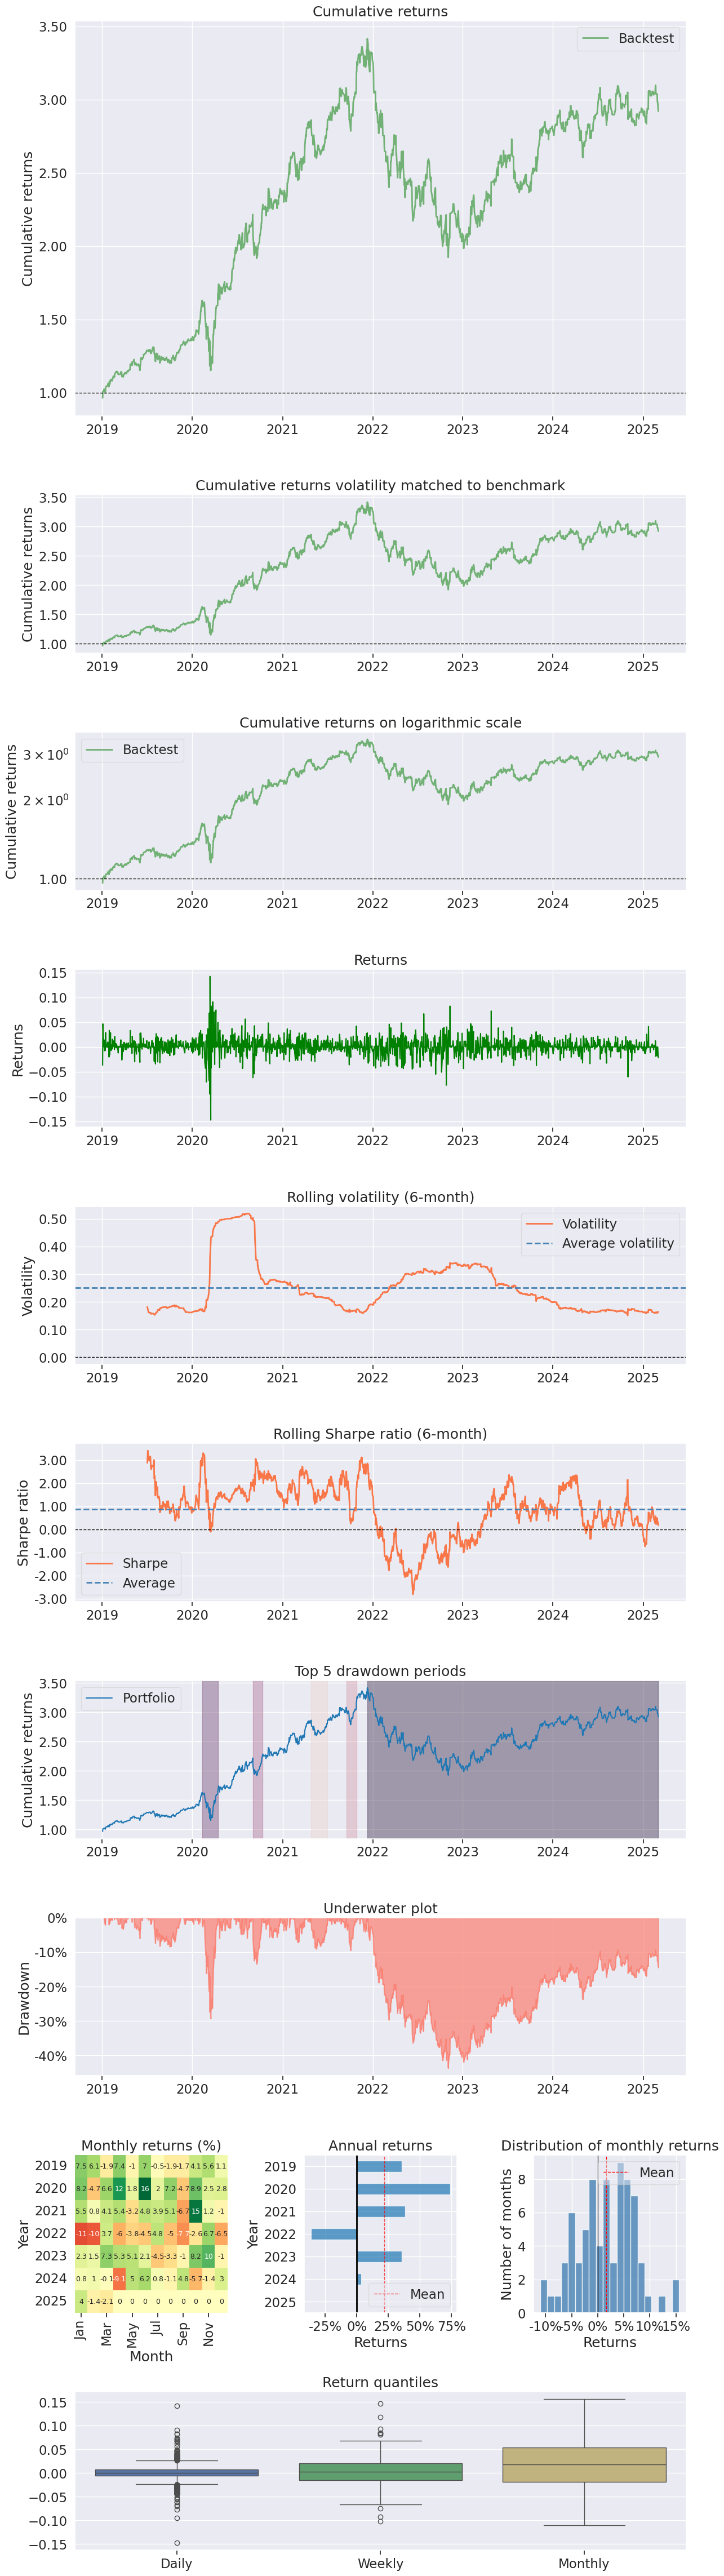

In [13]:
# Create the trading tear sheet for the strategy cumulative returns
pf.create_full_tear_sheet(ready_data['daily_stra_rets'].dropna())

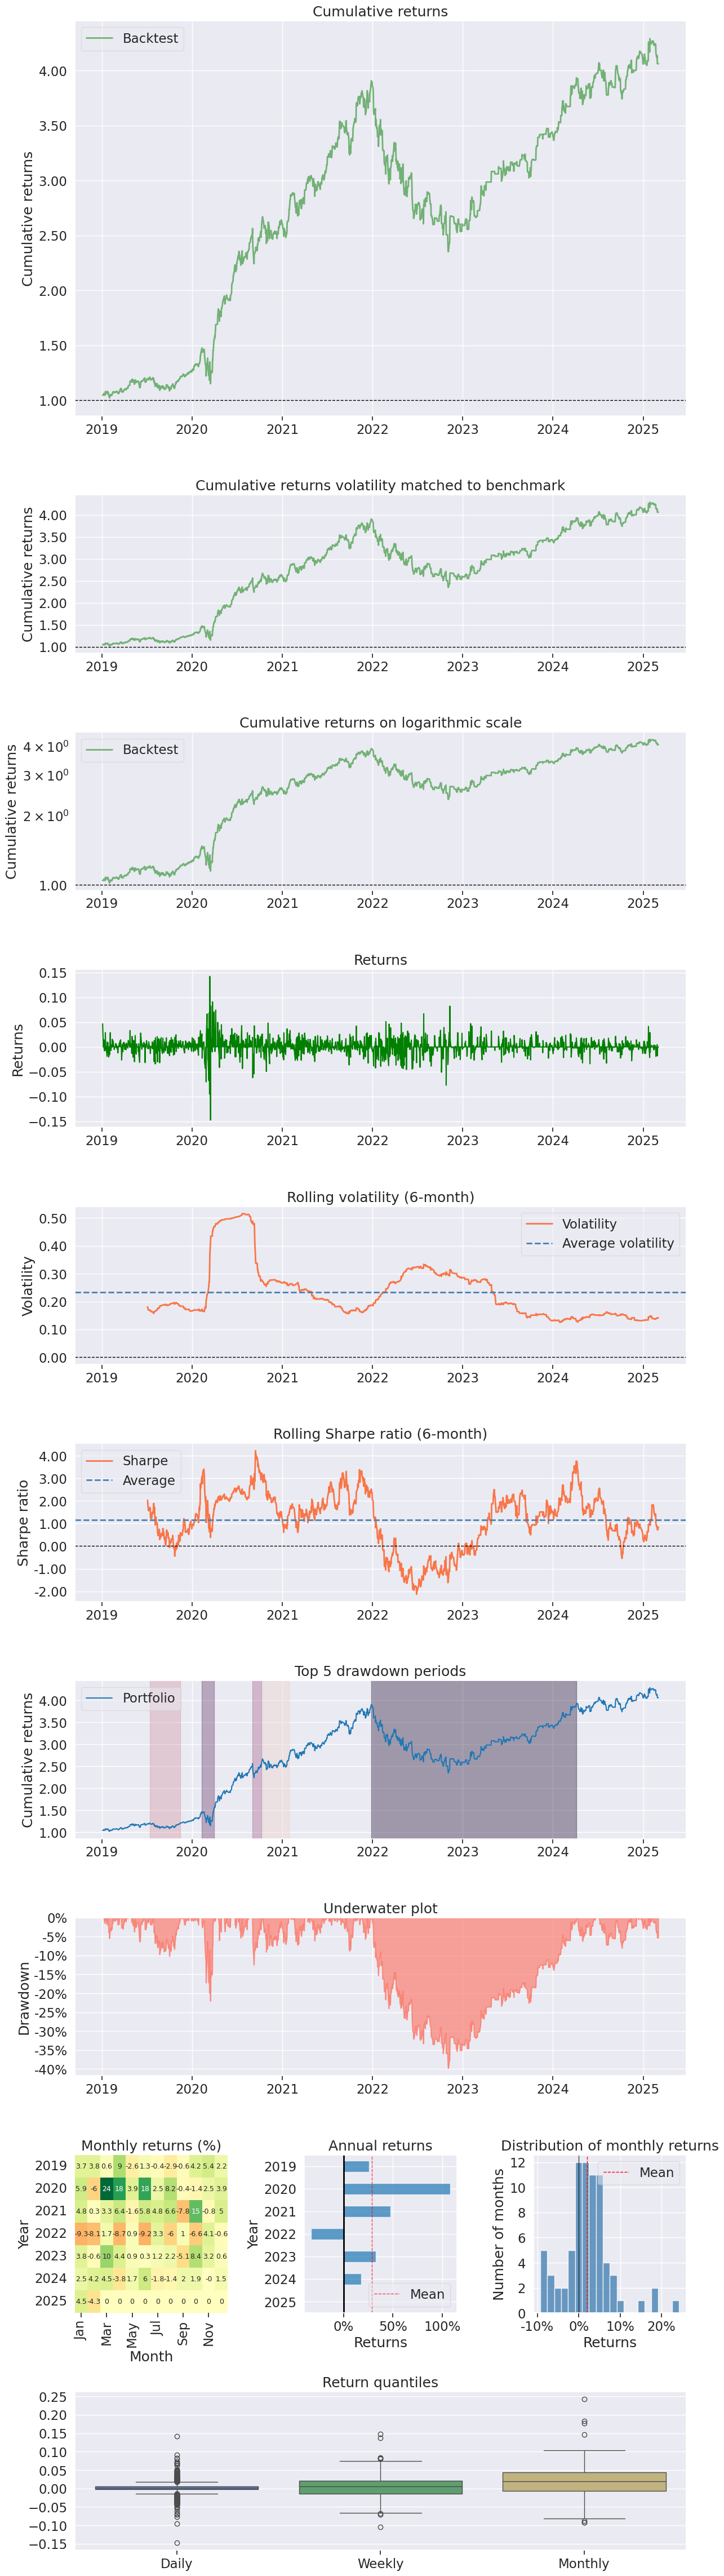

In [14]:
# Create the trading tear sheet for the strategy cumulative returns
pf.create_full_tear_sheet(ready_data['addm_stra_cum_rets'].pct_change().dropna())